In [51]:
##################################
# author: vedanshu
##################################


# import os
# os.environ["TF_ENABLE_WHILE_V2"]="1" 
# os.environ["TF_ENABLE_COND_V2"]="1"
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [33]:
grid_shape = (3,3) # (width, height)
image_shape=(150, 150) # (width, height) Width has to be equal to height
num_channels=3
MAX_DETECTION_IN_L2 = 10

In [34]:
pb_fname1 = "/Users/vedanshu/frozen_graph/ved_potato_l1_ssd_mobilenet_v2.pb"
pb_fname2 = "/Users/vedanshu/frozen_graph/ved_potato_l2_grid_3x3_faster_rcnn_inception_v2.pb"

In [35]:
img = cv2.imread("/Users/vedanshu/out.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [36]:
def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.GFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

In [37]:
def rename_frame_name(graphdef, suffix):
    # Bug reported at https://github.com/tensorflow/tensorflow/issues/22162#issuecomment-428091121
    for n in graphdef.node:
        if "while" in n.name:
            if "frame_name" in n.attr:
                n.attr["frame_name"].s = str(n.attr["frame_name"]).replace("while_context",
                                                                           "while_context" + suffix).encode('utf-8')


In [38]:
l1_graph = tf.Graph()
with l1_graph.as_default():
    trt_graph1 = get_frozen_graph(pb_fname1)
    [tf_input1, tf_scores1, tf_boxes1, tf_classes1, tf_num_detections1] = tf.import_graph_def(trt_graph1, 
            return_elements=['image_tensor:0', 'detection_scores:0', 'detection_boxes:0', 'detection_classes:0','num_detections:0'])

    input1 = tf.identity(tf_input1, name="l1_input")
    boxes1 = tf.identity(tf_boxes1[0], name="l1_boxes")  # index by 0 to remove batch dimension
    scores1 = tf.identity(tf_scores1[0], name="l1_scores")
    classes1 = tf.identity(tf_classes1[0], name="l1_classes")
    num_detections1 = tf.identity(tf.dtypes.cast(tf_num_detections1[0], tf.int32), name="l1_num_detections")

In [39]:
intermediate_graph = tf.Graph()

with intermediate_graph.as_default():
    def image_grid(input_tensor, grid_shape=(5,5), image_shape=(150, 150), num_channels=3):
        # https://github.com/tensorflow/tensorflow/blob/23c218785eac5bfe737eec4f8081fd0ef8e0684d/tensorflow/contrib/gan/python/eval/python/eval_utils_impl.py#L34
        height, width = grid_shape[0] * image_shape[0], grid_shape[1] * image_shape[1]
        input_tensor = tf.reshape(
          input_tensor, tuple(grid_shape) + tuple(image_shape) + (num_channels,))
        input_tensor = tf.transpose(input_tensor, [0, 1, 3, 2, 4])
        input_tensor = tf.reshape(
          input_tensor, [grid_shape[0], width, image_shape[0], num_channels])
        input_tensor = tf.transpose(input_tensor, [0, 2, 1, 3])
        input_tensor = tf.reshape(
          input_tensor, [height, width, num_channels])
        return input_tensor

    def get_grid_roies():
        def condition1(i, boxes_pixels):
            return tf.less(i, num_detections1)
        def body1(i, boxes_pixels):
            normalizer = [tf.shape(tf_input1[0])[0], tf.shape(tf_input1[0])[1], tf.shape(tf_input1[0])[0], tf.shape(tf_input1[0])[1]]
            box = tf.multiply(boxes1[i], tf.dtypes.cast(normalizer, tf.float32))
            box = tf.dtypes.cast(tf.round(box), tf.int32)
            boxes_pixels = boxes_pixels.write(i, box)
            return [tf.add(i, 1), boxes_pixels]

        i = tf.constant(0)
        boxes_pixels = tf.TensorArray(dtype=tf.int32,size=1,dynamic_size=True,clear_after_read=False)

        _, boxes_pixels = tf.while_loop(condition1,body1,[i, boxes_pixels])
        boxes_pixels = boxes_pixels.stack()

        def condition2(j, boxes_pixels, roies):
            return tf.less(j, tf.shape(boxes_pixels)[0])
        def body2(j, boxes_pixels, roies):
            startY =  boxes_pixels[j][0]
            startX =  boxes_pixels[j][1]
            endY =  boxes_pixels[j][2]
            endX =  boxes_pixels[j][3]
            roi = tf_input1[0, startY:endY, startX:endX] # batch: 0
            roi = tf.image.resize_image_with_pad(roi,image_shape[0],image_shape[1])
            roi = tf.dtypes.cast(roi, tf.uint8)
            roies = roies.write(j, roi)
            return [tf.add(j, 1), boxes_pixels, roies]

        j = tf.constant(0)
        roies = tf.TensorArray(dtype=tf.uint8,size=1,dynamic_size=True,clear_after_read=False,
                               infer_shape=False)

        _, _, roies = tf.while_loop(condition2,body2,[j, boxes_pixels, roies])

        # Adding padding for making grid
        roies = roies.stack()
        zero_pad = tf.zeros([1,image_shape[0],image_shape[1],num_channels], tf.uint8)
        _no_pad = tf.mod(tf.shape(roies)[0], tf.constant(grid_shape[0]*grid_shape[1]))
        no_pad = tf.cond(tf.equal(_no_pad, tf.constant(0)), lambda: tf.constant(0), 
                         lambda: tf.subtract(tf.constant(grid_shape[0]*grid_shape[1]), _no_pad))
        zero_pad = tf.tile(zero_pad, [no_pad,1,1,1])
        roies = tf.concat([roies, zero_pad], axis=0)

        # Creating batch of images of size grid_shape[0]*image_shape[0]
        size = grid_shape[0]*grid_shape[1]
        n_iter = tf.dtypes.cast(tf.divide(tf.shape(roies)[0], tf.constant(size)), tf.int32)
        k = tf.constant(0)
        grid_roies = tf.TensorArray(dtype=tf.uint8,size=1,dynamic_size=True,clear_after_read=False,infer_shape=False)

        def condition3(k, grid_roies):
            return tf.less(k, n_iter)

        def body3(k, grid_roies):
            grid_roi = image_grid(roies[size*k:size*(k+1)], grid_shape, image_shape, num_channels)
            grid_roies = grid_roies.write(k, grid_roi)
            return [tf.add(k, 1), grid_roies]

        _, grid_roies = tf.while_loop(condition3, body3, [k, grid_roies])

        grid_roies = grid_roies.stack() 

        return grid_roies, n_iter

    def create_empty_grid():
        grid_roies = tf.zeros([1,image_shape[0]*grid_shape[0],image_shape[1]*grid_shape[1],num_channels], tf.uint8)
        return grid_roies, 1


    l1_graph_def = l1_graph.as_graph_def()
    g1name = "level1"
    rename_frame_name(l1_graph_def, g1name)
    tf.import_graph_def(l1_graph_def, name=g1name)

    tf_input1 = tf.get_default_graph().get_tensor_by_name('level1/l1_input:0')
    boxes1 = tf.get_default_graph().get_tensor_by_name('level1/l1_boxes:0')
    scores1 = tf.get_default_graph().get_tensor_by_name('level1/l1_scores:0')
    classes1 = tf.get_default_graph().get_tensor_by_name('level1/l1_classes:0')
    num_detections1 = tf.get_default_graph().get_tensor_by_name('level1/l1_num_detections:0')

    # Grid is filled along the column first
    grid_roies, batch_size = tf.cond(tf.equal(num_detections1, tf.constant(0)), create_empty_grid, get_grid_roies)
    grid_roies = tf.identity(grid_roies, name="grid_roies_out")
    batch_size = tf.identity(batch_size, name="batch_size")


In [48]:
connected_graph = tf.Graph()
tf_sess_main = tf.Session(graph=connected_graph)

with connected_graph.as_default():
    intermediate_graph_def = intermediate_graph.as_graph_def()
    g1name = 'ved'
    rename_frame_name(intermediate_graph_def, g1name)
    tf.import_graph_def(intermediate_graph_def, name=g1name)
    
    tf_input = tf.get_default_graph().get_tensor_by_name('ved/level1/import/image_tensor:0')
    tf_grid_out = tf.get_default_graph().get_tensor_by_name('ved/grid_roies_out:0')
    tf_batch_size = tf.get_default_graph().get_tensor_by_name('ved/batch_size:0')
    tf_num_detections_l1 = tf.dtypes.cast(tf.get_default_graph().get_tensor_by_name('ved/level1/import/num_detections:0'), tf.int32)
    tf_boxes_l1 = tf.get_default_graph().get_tensor_by_name('ved/level1/import/detection_boxes:0')
    tf_scores_l1 = tf.get_default_graph().get_tensor_by_name('ved/level1/import/detection_scores:0')
    tf_classes_l1 = tf.get_default_graph().get_tensor_by_name('ved/level1/import/detection_classes:0')
    
    trt_graph2 = get_frozen_graph(pb_fname2)
    g2name = 'level2'
    rename_frame_name(trt_graph2, g2name)
    [tf_scores, tf_boxes, tf_classes, tf_num_detections] = tf.import_graph_def(trt_graph2,
            input_map={'image_tensor': tf_grid_out},
            return_elements=['detection_scores:0', 'detection_boxes:0', 'detection_classes:0','num_detections:0'])
    
    
    # Only for debugging
    grid_boxes_l2, grid_scores_l2, grid_img  = tf_sess_main.run([tf_boxes, tf_scores, tf_grid_out], 
                                                        {tf_input: img[None, ...]})
    
    
    boxes_l1 = tf_boxes_l1[0] # Assuming batch size of 1 in level 1
    ip_image_height = tf.shape(tf_input[0])[0]
    ip_image_width = tf.shape(tf_input[0])[1]
    boxes_l1 = boxes_l1 * tf.dtypes.cast([ip_image_height, ip_image_width, ip_image_height, ip_image_width], tf.float32)
    boxes_l1 = tf.dtypes.cast(boxes_l1, tf.int32)
    tf_boxes_l1 = tf.expand_dims(boxes_l1, 0)
    
    def getSquareImageFactors( img_width, img_height, target_width ):
        max_dim = tf.cond(img_width >= img_height, lambda: img_width, lambda: img_height)
        scale = target_width / max_dim
        
        def getScaledHeight(img_width, img_height, target_width, scale):
            x = 0
            img_height = tf.dtypes.cast(tf.dtypes.cast(img_height, tf.float64) * scale, tf.int32)
            y = tf.dtypes.cast(( target_width - img_height ) / 2, tf.int32)
            return x,y
        def getScaledWidth(img_width, img_height, target_width, scale):
            y = 0
            img_width = tf.dtypes.cast(tf.dtypes.cast(img_width, tf.float64) * scale, tf.int32)
            x = tf.dtypes.cast(( target_width - img_width ) / 2, tf.int32)
            return x,y
        
        x, y = tf.cond(img_width >= img_height, lambda: getScaledHeight(img_width, img_height, target_width, scale), 
                       lambda: getScaledWidth(img_width, img_height, target_width, scale))
        
        return x, y, scale
        
    def condition1(i, tf_boxes_l2, tf_scores_l2, tf_classes_l2, batch_arr_original_index):
        return tf.less(i, tf_batch_size)
    def body1(i, tf_boxes_l2, tf_scores_l2, tf_classes_l2, batch_arr_original_index):
        boxes_l2 = tf_boxes[i]
        scores_l2 = tf_scores[i]
        classes_l2 = tf_classes[i]
        num_detections_l2 = tf.dtypes.cast(tf_num_detections[i], tf.int32)
        
        grid_height = image_shape[0]*grid_shape[0]
        grid_width = image_shape[1]*grid_shape[1]
        boxes_l2 = boxes_l2 * tf.dtypes.cast(tf.constant([grid_height, grid_width, grid_height, grid_width]), tf.float32)
        boxes_index = boxes_l2/tf.dtypes.cast(tf.constant(image_shape[0]), tf.float32)
        boxes_index = tf.dtypes.cast(boxes_index, tf.int32)
        boxes_l2 = tf.dtypes.cast(boxes_l2, tf.int32)
        
        
        def condition2(j, arr_boxes_l2, arr_original_index):
            return tf.less(j, tf.shape(boxes_index)[0])
        def body2(j, arr_boxes_l2, arr_original_index):
            def update_boxes(arr_boxes_l2, arr_original_index):
                y = boxes_index[j][0]
                x = boxes_index[j][1]
                original_index = i*grid_shape[0]*grid_shape[1] + y*tf.constant(grid_shape[0]) + x # indexed zero

                arr_original_index = arr_original_index.write(j, original_index)
                
                _x, _y, _scale = getSquareImageFactors(boxes_l1[original_index][3] - boxes_l1[original_index][1],
                                               boxes_l1[original_index][2] - boxes_l1[original_index][0],
                                               image_shape[1] )
                
                _y1 = tf.dtypes.cast(tf.dtypes.cast(boxes_l2[j][0] - y*tf.constant(image_shape[1]) - _y, tf.float64) / _scale, tf.int32)
                _x1 = tf.dtypes.cast(tf.dtypes.cast(boxes_l2[j][1] - x*tf.constant(image_shape[0]) - _x, tf.float64) / _scale, tf.int32)
                _y2 = tf.dtypes.cast(tf.dtypes.cast(boxes_l2[j][2] - y*tf.constant(image_shape[1]) - _y, tf.float64) / _scale, tf.int32)
                _x2 = tf.dtypes.cast(tf.dtypes.cast(boxes_l2[j][3] - x*tf.constant(image_shape[0]) - _x, tf.float64) / _scale, tf.int32)

                arr_boxes_l2 = arr_boxes_l2.write(j, [boxes_l1[original_index][0] + _y1,
                                                      boxes_l1[original_index][1] + _x1,
                                                      boxes_l1[original_index][0] + _y2,
                                                      boxes_l1[original_index][1] + _x2])
                return [arr_boxes_l2, arr_original_index]

            def update_with_null(arr_boxes_l2, arr_original_index):
                y = boxes_index[j][0]
                x = boxes_index[j][1]
                original_index = y*tf.constant(grid_shape[0]) + x
                arr_original_index = arr_original_index.write(j, original_index)
                arr_boxes_l2 = arr_boxes_l2.write(j,[0,0,0,0])
                return [arr_boxes_l2, arr_original_index]

            arr_boxes_l2, arr_original_index = tf.cond(tf.math.logical_and(tf.math.equal(boxes_index[j][0],boxes_index[j][2]),
                                                                           tf.math.equal(boxes_index[j][1],boxes_index[j][3])),
                                                       lambda: update_boxes(arr_boxes_l2, arr_original_index), 
                                                       lambda: update_with_null(arr_boxes_l2, arr_original_index))
            return [tf.add(j, 1), arr_boxes_l2, arr_original_index]

        j = tf.constant(0)
        arr_boxes_l2 = tf.TensorArray(dtype=tf.int32,size=1, dynamic_size=True,clear_after_read=False)
        arr_original_index = tf.TensorArray(dtype=tf.int32,size=1, dynamic_size=True,clear_after_read=False)
        j, arr_boxes_l2, arr_original_index = tf.while_loop(condition2, body2, [j, arr_boxes_l2, arr_original_index])
        boxes_l2 = arr_boxes_l2.stack()
        original_index = arr_original_index.stack()
        
        inds = tf.argsort(original_index,axis=-1,direction='ASCENDING',stable=False,name=None)
        boxes_l2 = tf.gather(boxes_l2, inds)
        original_index = tf.gather(original_index, inds)
        scores_l2 = tf.gather(scores_l2, inds)
        classes_l2 = tf.gather(classes_l2, inds)
        
        original_index, idx = tf.unique(original_index)
        batch_arr_original_index = batch_arr_original_index.write(i, original_index)
        partitioned_boxes_l2 = tf.dynamic_partition(boxes_l2, idx, grid_shape[0]*grid_shape[1])
        partitioned_scores_l2 = tf.dynamic_partition(scores_l2, idx, grid_shape[0]*grid_shape[1])
        partitioned_classes_l2 = tf.dynamic_partition(classes_l2, idx, grid_shape[0]*grid_shape[1])

        for u in range(len(partitioned_boxes_l2)):
            _x = tf.constant(MAX_DETECTION_IN_L2) - tf.shape(partitioned_boxes_l2[u])[0]
            _r = tf.cond(tf.less(_x, 0), lambda: tf.constant(0), lambda: tf.identity(_x))
            pad = tf.tile(tf.zeros([1,4], tf.int32), [_r, 1])
            partitioned_boxes_l2[u] = tf.concat([partitioned_boxes_l2[u][:MAX_DETECTION_IN_L2],pad], 0)

        for u in range(len(partitioned_scores_l2)):
            _x = tf.constant(MAX_DETECTION_IN_L2) - tf.shape(partitioned_scores_l2[u])[0]
            _r = tf.cond(tf.less(_x, 0), lambda: tf.constant(0), lambda: tf.identity(_x))
            pad = tf.tile(tf.zeros([1], tf.float32), [_r])
            partitioned_scores_l2[u] = tf.concat([partitioned_scores_l2[u][:MAX_DETECTION_IN_L2],pad], 0)
            
        for u in range(len(partitioned_classes_l2)):
            _x = tf.constant(MAX_DETECTION_IN_L2) - tf.shape(partitioned_classes_l2[u])[0]
            _r = tf.cond(tf.less(_x, 0), lambda: tf.constant(0), lambda: tf.identity(_x))
            pad = tf.tile(tf.zeros([1], tf.float32), [_r])
            partitioned_classes_l2[u] = tf.concat([partitioned_classes_l2[u][:MAX_DETECTION_IN_L2],pad], 0)

        partitioned_boxes_l2 = tf.convert_to_tensor(partitioned_boxes_l2)
        partitioned_scores_l2 = tf.convert_to_tensor(partitioned_scores_l2)
        partitioned_classes_l2 = tf.convert_to_tensor(partitioned_classes_l2)
        tf_boxes_l2 = tf_boxes_l2.write(i, partitioned_boxes_l2)
        tf_scores_l2 = tf_scores_l2.write(i, partitioned_scores_l2)
        tf_classes_l2 = tf_classes_l2.write(i, partitioned_classes_l2)
        
        return [tf.add(i, 1), tf_boxes_l2, tf_scores_l2, tf_classes_l2, batch_arr_original_index]
        
    i = tf.constant(0)
    tf_boxes_l2 = tf.TensorArray(dtype=tf.int32,size=1,dynamic_size=True,clear_after_read=False, name='tf_arr_boxes_l2')
    tf_scores_l2 = tf.TensorArray(dtype=tf.float32,size=1,dynamic_size=True,clear_after_read=False, name='tf_arr_scores_l2')
    tf_classes_l2 = tf.TensorArray(dtype=tf.float32,size=1,dynamic_size=True,clear_after_read=False, name='tf_arr_classes_l2')
    batch_arr_original_index = tf.TensorArray(dtype=tf.int32,size=1, dynamic_size=True,clear_after_read=False)
    _, tf_boxes_l2, tf_scores_l2, tf_classes_l2, batch_arr_original_index = tf.while_loop(condition1, body1, [i, tf_boxes_l2, tf_scores_l2, tf_classes_l2, batch_arr_original_index])
    
    tf_boxes_l2 = tf_boxes_l2.stack()
    tf_scores_l2 = tf_scores_l2.stack()
    tf_classes_l2 = tf_classes_l2.stack()
    batch_arr_original_index = batch_arr_original_index.stack()
    
    tf_original_index_l2 = tf.squeeze(batch_arr_original_index, name="original_index_l2")
    
    tf_boxes_l2 = tf.reshape(tf_boxes_l2, [-1,MAX_DETECTION_IN_L2,4])
    tf_scores_l2 = tf.reshape(tf_scores_l2, [-1, MAX_DETECTION_IN_L2])
    tf_classes_l2 = tf.reshape(tf_classes_l2, [-1, MAX_DETECTION_IN_L2])
    
    _indices = tf.expand_dims(tf_original_index_l2, 1)
    
    _sliced_boxes_l2 = tf.slice(tf_boxes_l2, [0, 0, 0], [tf.shape(tf_original_index_l2)[0], -1, -1])
    _shape_boxes_l2 = tf.shape(tf_boxes_l2)
    tf_boxes_l2 = tf.scatter_nd(_indices, _sliced_boxes_l2, _shape_boxes_l2, name="detection_boxes_l2")
    
    _sliced_scores_l2 = tf.slice(tf_scores_l2, [0, 0], [tf.shape(tf_original_index_l2)[0], -1])
    _shape_scores_l2 = tf.shape(tf_scores_l2)
    tf_scores_l2 = tf.scatter_nd(_indices, _sliced_scores_l2, _shape_scores_l2, name="detection_scores_l2")
    
    _sliced_classes_l2 = tf.slice(tf_classes_l2, [0, 0], [tf.shape(tf_original_index_l2)[0], -1])
    _shape_classes_l2 = tf.shape(tf_classes_l2)
    tf_classes_l2 = tf.scatter_nd(_indices, _sliced_classes_l2, _shape_classes_l2, name="detection_classes_l2")
    
    tf_boxes_l1 = tf.squeeze(tf_boxes_l1, name="detection_boxes_l1")
    tf_scores_l1 = tf.squeeze(tf_scores_l1, name="detection_scores_l1")
    tf_classes_l1 = tf.squeeze(tf_classes_l1, name="detection_classes_l1")
    
    tf_max_num_detection = tf.identity(tf.shape(tf_boxes_l2)[0], name="max_num_detections")
    
out_boxes_l1, out_scores_l1, out_classes_l1, out_boxes_l2, out_scores_l2, out_classes_l2  = tf_sess_main.run([tf_boxes_l1, tf_scores_l1, tf_classes_l1, tf_boxes_l2, tf_scores_l2, tf_classes_l2], 
                                                                             {tf_input: img[None, ...]})
    

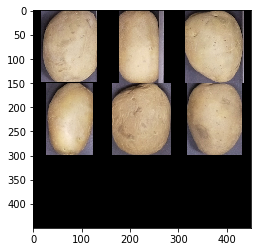

In [52]:
plt.imshow(grid_img[0])

True

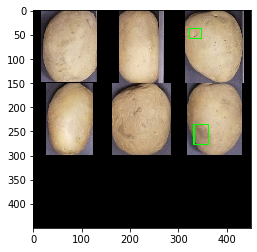

In [60]:
_img_out = grid_img[0].copy()
grid_size = image_shape[0]*grid_shape[0]

grid_boxes_l2 = grid_boxes_l2[0]
grid_boxes_l2 = grid_boxes_l2* np.array([grid_size, grid_size, grid_size, grid_size])
grid_boxes_l2 = grid_boxes_l2.astype(int)

for i in range(grid_boxes_l2.shape[0]):
    startY, startX, endY, endX = grid_boxes_l2[i]
    cv2.rectangle(_img_out, (startX, startY),(endX, endY), (0, 255, 0), 2)
plt.imshow(_img_out)
image = cv2.cvtColor(_img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('out_grid_l2.jpg', image)

True

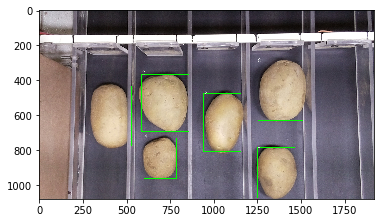

In [44]:
_img_out = img.copy()
for j in range(out_boxes_l1.shape[0]):
    startY_l1, startX_l1, endY_l1, endX_l1 = out_boxes_l1[j]
    cv2.rectangle(_img_out, (startX_l1, startY_l1),
                  (endX_l1, endY_l1), (0, 255, 0), 2)
    cv2.putText(_img_out, str(j), (startX_l1, startY_l1), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
plt.imshow(_img_out)
image = cv2.cvtColor(_img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('out_l1.jpg', image)

True

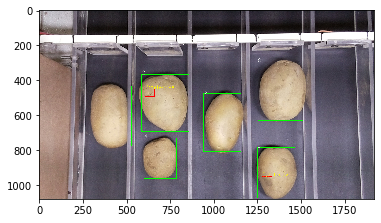

In [46]:
# _img_out = img.copy()
labels = ["defective", "normal"]
for j in range(out_boxes_l2.shape[0]):
    for i in range(out_boxes_l2.shape[1]):
        if out_scores_l2[j][i] > 0.5:
            startY_l2, startX_l2, endY_l2, endX_l2 = out_boxes_l2[j][i]
            cv2.rectangle(_img_out, (startX_l2, startY_l2),
                          (endX_l2, endY_l2), (255, 0, 0), 2)
            cv2.putText(_img_out, str(j)+';'+labels[int(out_classes_l2[j][i])-1], (startX_l2, startY_l2), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), lineType=cv2.LINE_AA)
        
plt.imshow(_img_out)
image = cv2.cvtColor(_img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('out_with_l2.jpg', image)

In [47]:
import os
import shutil

with connected_graph.as_default():
    print('\nSaving...')
    cwd = os.getcwd()
    path = os.path.join(cwd, 'saved_model')
    shutil.rmtree(path, ignore_errors=True)
    inputs_dict = {
        "image_tensor": tf_input
    }
    outputs_dict = {
        "detection_boxes_l1": tf_boxes_l1,
        "detection_scores_l1": tf_scores_l1,
        "detection_classes_l1": tf_classes_l1,
        "max_num_detection": tf_max_num_detection,
        "detection_boxes_l2": tf_boxes_l2,
        "detection_scores_l2": tf_scores_l2,
        "detection_classes_l2": tf_classes_l2,
    }
    tf.saved_model.simple_save(
        tf_sess_main, path, inputs_dict, outputs_dict
    )
    print('Ok')


Saving...
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /Users/vedanshu/tfrecord/saved_model/saved_model.pb
Ok


# Code from here is only for debugging 

True

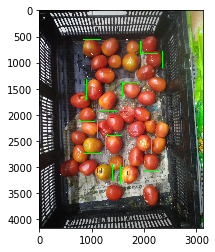

In [13]:
import matplotlib.pyplot as plt

def getSquareImageFactors( img_width, img_height, target_width = 500 ):
    max_dim = img_width if img_width >= img_height else img_height
    scale = target_width / max_dim
    if ( img_width >= img_height ):
        x = 0
        img_height = int(img_height * scale)
        y = int(( target_width - img_height ) / 2)
    else:
        y = 0
        img_width = int(img_width * scale)
        x = int(( target_width - img_width ) / 2)
    return x, y, scale

BATCH = 0
grid_img_out = grid_img[BATCH]
boxes_l2 = boxes_l2[BATCH]
boxes_l1 = boxes_l1[0]
boxes_l1 = boxes_l1 * np.array([img.shape[0], img.shape[1], img.shape[0], img.shape[1]])
boxes_l1 = boxes_l1.astype(int)
scores_l2_out = scores_l2[BATCH]

grid_size = image_shape[0]*grid_shape[0]
boxes_l2 = boxes_l2 * np.array([grid_size, grid_size, grid_size, grid_size])
boxes_l2_bck = boxes_l2
boxes_l2_index = boxes_l2/150
boxes_l2_index = boxes_l2_index.astype(int)
boxes_l2 = boxes_l2.astype(int)

_img_out = img.copy()
for j in range(boxes_l1.shape[0]):
    startY_l1, startX_l1, endY_l1, endX_l1 = boxes_l1[j]
    cv2.rectangle(_img_out, (startX_l1, startY_l1),
                  (endX_l1, endY_l1), (0, 255, 0), 2)
    cv2.putText(_img_out, str(j), (startX_l1, startY_l1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
plt.imshow(_img_out)
image = cv2.cvtColor(_img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('out_l1.jpg', image)


for j in range(boxes_l2.shape[0]):
    if scores_l2_out[j] > 0.5:
        startY_l2, startX_l2, endY_l2, endX_l2 = boxes_l2[j]
        grid_img_out = cv2.rectangle(grid_img_out, (startX_l2, startY_l2), 
                              (endX_l2, endY_l2), (255, 0, 0), 2)
plt.imshow(grid_img_out)
image = cv2.cvtColor(grid_img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('out_grid.jpg', image)
        
k = 0

for i in range(boxes_l2.shape[0]):
    if scores_l2_out[i] > 0.5 and boxes_l2_index[i][0] == boxes_l2_index[i][2] and boxes_l2_index[i][1] == boxes_l2_index[i][3]:
        y = boxes_l2_index[i][0]
        x = boxes_l2_index[i][1]
        original_index = BATCH*grid_shape[0]*grid_shape[0] + y*grid_shape[0] + x # indexed zero
        _x, _y, _scale = getSquareImageFactors(boxes_l1[original_index][3] - boxes_l1[original_index][1],
                                               boxes_l1[original_index][2] - boxes_l1[original_index][0],
                                               image_shape[1] )
        
        boxes_l2[i][0] = int((boxes_l2[i][0] - y*image_shape[1] -_y)/ _scale)
        boxes_l2[i][1] = int((boxes_l2[i][1] - x*image_shape[0] - _x)/ _scale)
        boxes_l2[i][2] = int((boxes_l2[i][2] - y*image_shape[1] - _y)/ _scale)
        boxes_l2[i][3] = int((boxes_l2[i][3] - x*image_shape[0] - _x)/ _scale)

        startY_l1, startX_l1, endY_l1, endX_l1 = boxes_l1[original_index]
        startY_l2, startX_l2, endY_l2, endX_l2 = boxes_l2[i]
        
        _img_out = cv2.rectangle(_img_out, (startX_l1 + startX_l2, startY_l1 + startY_l2),
                                 (startX_l1 + endX_l2, startY_l1 + endY_l2), (255, 0, 0), 2)
plt.imshow(_img_out)
_img_out = cv2.cvtColor(_img_out, cv2.COLOR_BGR2RGB)
cv2.imwrite('out.jpg', _img_out)  

        


In [149]:
boxes_l2_bck

array([[ 40.41387979, 464.10034597, 127.81205401, 542.02111065],
       [210.84771305, 188.2404238 , 242.4421683 , 221.08118981],
       [ 53.00435051, 177.46859416,  86.65798791, 209.45218205],
       [337.24652231,  33.38928614, 418.99627447,  81.39854483],
       [347.52559662, 633.18179548, 395.98582685, 681.26285076],
       [434.29675698,  11.89070055, 481.01788759, 127.43243203],
       [487.36980557, 183.14132094, 538.95230591, 219.08913553],
       [ 32.44815487,  50.04100129,  54.99091744,  76.65875182],
       [224.41010177, 698.401317  , 296.83727771, 740.05351961],
       [  5.19079983, 453.26752961,  38.72837685, 503.40677798],
       [252.85571069, 603.11982036, 292.70164669, 656.90253675],
       [625.87603927, 510.97333431, 674.63091016, 573.58945906],
       [185.28399244, 481.32790625, 223.90823811, 502.67533958],
       [487.44812608,  46.46318033, 531.73841536,  72.11734727],
       [237.22218722, 213.06417882, 270.90963721, 244.67550963],
       [302.95224488, 111

In [13]:
grid_img.shape

(2, 750, 750, 3)

In [14]:
import matplotlib.pyplot as plt

for i in range(out_boxes_l2.shape[0]):
    startY_l1, startX_l1, endY_l1, endX_l1 = out_boxes_l1[i]
    image = cv2.rectangle(img, (startX_l1 , startY_l1 ),
                          (endX_l1 , endY_l1 ), (0, 255, 0), 2)
    for j in range(out_boxes_l2.shape[1]):
        if out_scores_l2[i][j] > 0.5:
            startY_l2, startX_l2, endY_l2, endX_l2 = out_boxes_l2[i][j]
            image = cv2.rectangle(image, (startX_l1 + startX_l2, startY_l1 + startY_l2), 
                                  (endX_l1 + endX_l2, endY_l1 + endY_l2), (255, 0, 0), 2)
        
plt.imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite('out.jpg', image)

NameError: name 'out_boxes_l2' is not defined

In [10]:
out_boxes_l2.shape

(50, 10, 4)

In [91]:
grid_size = image_shape[0]*grid_shape[0]
boxes_out = boxes_out * np.array([grid_size, grid_size, grid_size, grid_size])
boxes_out_index = boxes_out/150
boxes_out_index = boxes_out_index.astype(int)
boxes_out = boxes_out.astype(int)

for i in range(len(boxes_out_index)):
    if boxes_out_index[i][0] == boxes_out_index[i][2] and boxes_out_index[i][1] == boxes_out_index[i][3]:
        y = boxes_out_index[i][0]
        x = boxes_out_index[i][1]
        original_index = y*grid_shape[0] + x # indexed zero
        
        boxes_out[i][0] = boxes_out[i][0] - y*image_shape[1]
        boxes_out[i][1] = boxes_out[i][1] - x*image_shape[0]
        boxes_out[i][2] = boxes_out[i][2] - y*image_shape[1]
        boxes_out[i][3] = boxes_out[i][3] - x*image_shape[0]
        

In [92]:
boxes_out

array([[ 40,  14, 127,  92],
       [ 60,  38,  92,  71],
       [ 53,  27,  86,  59],
       [ 37,  33, 118,  81],
       [ 47,  33,  95,  81],
       [434,  11, 481, 127],
       [ 37,  33,  88,  69],
       [ 32,  50,  54,  76],
       [ 74,  98, 146, 140],
       [  5,   3,  38,  53],
       [102,   3, 142,  56],
       [ 25,  60,  74, 123],
       [ 35,  31,  73,  52],
       [ 37,  46,  81,  72],
       [ 87,  63, 120,  94],
       [  2, 111,  23, 129],
       [ 63,  16,  85,  31],
       [ 35,  50,  89,  83],
       [ 58,  40,  85,  68],
       [556,  11, 600,  46],
       [  3,  94,  28, 127],
       [  9, 113,  39, 147],
       [ 41,  54,  88,  81],
       [551,   7, 603,  48],
       [ 95,   9, 135,  50],
       [ 96,   8, 136,  48],
       [596, 614, 629, 650],
       [ 11, 111,  41, 149],
       [142,  96, 184, 125],
       [  9,   8,  39,  54],
       [ 53,  46,  99,  63],
       [594, 612, 630, 651],
       [ 12, 100,  34, 135],
       [106,  22, 144,  60],
       [  4,  

In [137]:
boxes_out_index

array([[0, 3, 0, 3],
       [1, 1, 1, 1],
       [0, 1, 0, 1],
       [2, 0, 2, 0],
       [2, 4, 2, 4],
       [2, 0, 3, 0],
       [3, 1, 3, 1],
       [0, 0, 0, 0],
       [1, 4, 1, 4],
       [0, 3, 0, 3],
       [1, 4, 1, 4],
       [4, 3, 4, 3],
       [1, 3, 1, 3],
       [3, 0, 3, 0],
       [1, 1, 1, 1],
       [2, 0, 2, 0],
       [2, 2, 2, 2],
       [0, 2, 0, 2],
       [2, 1, 2, 1],
       [3, 0, 4, 0],
       [0, 0, 0, 0],
       [2, 2, 2, 2],
       [0, 2, 0, 2],
       [3, 0, 4, 0],
       [2, 4, 2, 4],
       [2, 4, 2, 4],
       [3, 4, 4, 4],
       [2, 2, 2, 2],
       [0, 0, 1, 0],
       [2, 4, 2, 4],
       [3, 4, 3, 4],
       [3, 4, 4, 4],
       [4, 2, 4, 2],
       [1, 0, 1, 0],
       [2, 3, 2, 3],
       [0, 3, 0, 3],
       [3, 1, 3, 2],
       [1, 2, 1, 2],
       [2, 0, 2, 0],
       [2, 3, 2, 3],
       [0, 3, 0, 3],
       [0, 0, 0, 0],
       [2, 2, 2, 2],
       [3, 4, 4, 4],
       [4, 3, 4, 3],
       [1, 0, 1, 0],
       [0, 4, 0, 4],
       [4, 4,

In [10]:
import matplotlib.pyplot as plt
plt.imshow(grid_roies_out[0])

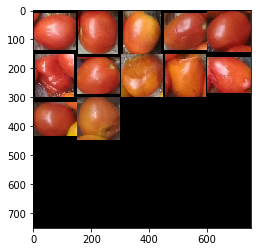

In [11]:
plt.imshow(grid_roies_out[1])

In [54]:
n = 5

def c(i,x):
    return i < n
    
def b(i, x):
    def _c(j,y):
        return tf.less(j, i)

    def _b(j, y):
        def true_c(y):
            y = y.write(j, [j,j,j,j])
            return y
            
        def false_c(y):
            y = y.write(j, [0,1,1,0])
            return y
        
        y = tf.cond(j>0, lambda: true_c(y), lambda: false_c(y))
        return [tf.add(j,1), y]
    

    y = tf.TensorArray(dtype=tf.int32,size=1, dynamic_size=True,clear_after_read=False)
    _, y = tf.while_loop(_c, _b, (tf.constant(0), y))
    y = y.stack()
    pad = tf.tile(tf.zeros([1,4], tf.int32), [n - tf.shape(y)[0], 1])
    y = tf.concat([y,pad], 0)
    x = x.write(i, y)
    return [i+1, x]

x = tf.TensorArray(dtype=tf.int32,size=1, dynamic_size=True,clear_after_read=False)
_, out = tf.while_loop(c, b, (tf.constant(0), x))
out = out.stack()

with tf.compat.v1.Session() as sess:
    print(sess.run(out))


[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 1 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 1 0]
  [1 1 1 1]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 1 0]
  [1 1 1 1]
  [2 2 2 2]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 1 1 0]
  [1 1 1 1]
  [2 2 2 2]
  [3 3 3 3]
  [0 0 0 0]]]


In [190]:
value = tf.constant([1,2,2,3,3,3,4,4,4,4,5,5,5,5,5])
y, idx, count = tf.unique_with_counts(value)
partitions = idx
out = tf.dynamic_partition(value, partitions, 5)

for i in range(len(out)):
    paddings = [[ 0, MAX_D - tf.shape(out[i])[0] ]]
    out[i] = tf.pad(out[i], paddings, "CONSTANT")
    
out = tf.convert_to_tensor(out)

with tf.compat.v1.Session() as sess:
    print( sess.run(out) )

[[1 0 0 0 0]
 [2 2 0 0 0]
 [3 3 3 0 0]
 [4 4 4 4 0]
 [5 5 5 5 5]]


In [296]:
def _c(j,y):
    return tf.less(j, 5)

def _b(j, y):
    y = y.write(j, [j,j,j,j])
    return [tf.add(j,1), y]

y = tf.TensorArray(dtype=tf.int32,size=1, dynamic_size=True,clear_after_read=False)
j = tf.constant(0)
_, y = tf.while_loop(_c, _b, (j, y))
y = y.stack()
pad = tf.tile(tf.zeros([1,4], tf.int32), [5 - tf.shape(y)[0], 1])
y = tf.concat([y,pad], 0)

with tf.compat.v1.Session() as sess:
    print(sess.run(y))

[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]]


In [212]:
a = tf.constant([[1,2,3,4]])
b = tf.tile(a,[3,1])

with tf.compat.v1.Session() as sess:
    print(sess.run(b))

[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]


In [102]:
y = tf.tile(tf.zeros([1], tf.int32), [MAX_D])
with tf.compat.v1.Session() as sess:
    print(sess.run(y))

[0 0 0 0 0]


In [8]:
input = tf.constant([[[ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217],
    [ 298, 1217,  298, 1217]],

   [[ 450,  607,  493,  662],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0]],

   [[ 950, 1277, 1028, 1335],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0]],

   [[   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0]],

   [[   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0]],

   [[   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0]],

   [[   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0]],

   [[   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0]],

   [[   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0],
    [   0,    0,    0,    0]]])

x = tf.constant([0, 2, 5])
indices = tf.expand_dims(x, 1)
sliced_input = tf.slice(input, [0, 0, 0], [tf.shape(x)[0], -1, -1])
shape = tf.shape(input)
output = tf.scatter_nd(indices, sliced_input, shape)

with tf.compat.v1.Session() as sess:
    print(sess.run(output))

[[[ 298 1217  298 1217]
  [ 298 1217  298 1217]
  [ 298 1217  298 1217]
  [ 298 1217  298 1217]
  [ 298 1217  298 1217]
  [ 298 1217  298 1217]
  [ 298 1217  298 1217]
  [ 298 1217  298 1217]
  [ 298 1217  298 1217]
  [ 298 1217  298 1217]]

 [[   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]]

 [[ 450  607  493  662]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]]

 [[   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]]

 [[   0    0    0    0]
  [   0 